<a href="https://colab.research.google.com/github/AdrienVansuyt/Python-Quant-Exercices/blob/main/BOT_BTC_SL/TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **From 10K to 1M in 2 years trading (only sell) single print on BTC**

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 6666.67, Capital Before: 10000.00, Position Size: 13.33, Capital After: 16666.67
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 6666.67, Capital Before: 16666.67, Position Size: 13.33, Capital After: 23333.33
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 6666.67, Capital Before: 23333.33, Position Size: 13.33, Capital After: 30000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 6666.67, Capital Before: 30000.00, Position Size: 13.33, Capital After: 36666.67
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 6666.67, Capital Before: 36666.67, Position Size: 13.33, Capital After: 43333.33
Sell tra

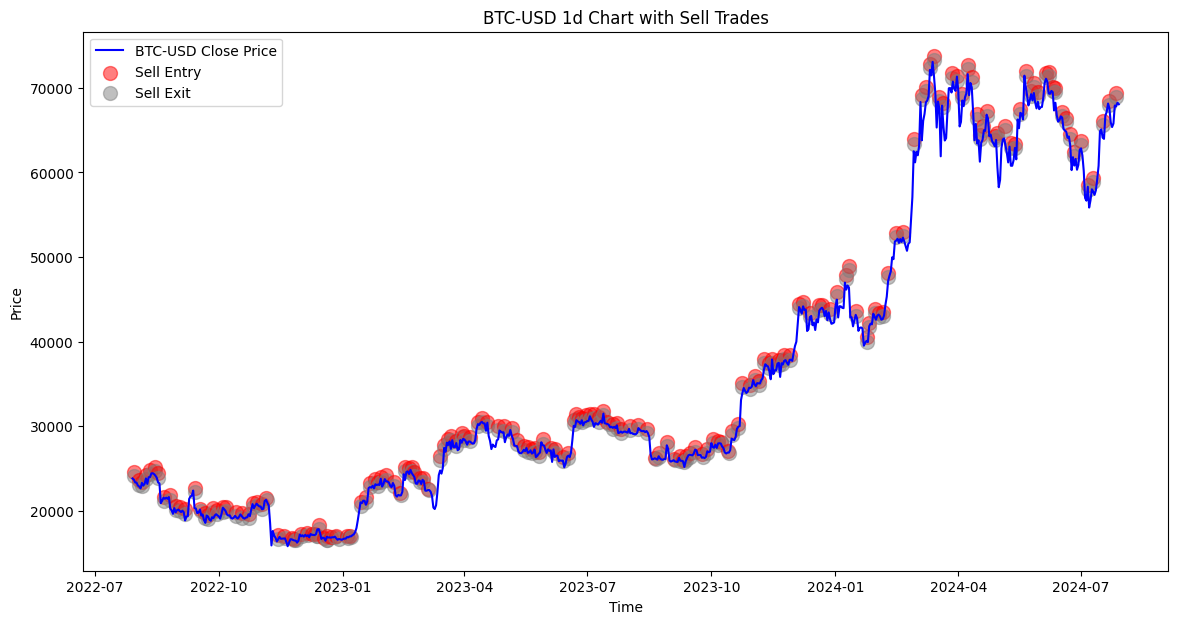


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  6666.67   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  6666.67   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  6666.67   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  6666.67   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  6666.67   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  6666.67   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  6666.67   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  6666.67   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  6666.67   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  6666.67   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          13.33             16666.67  
1        

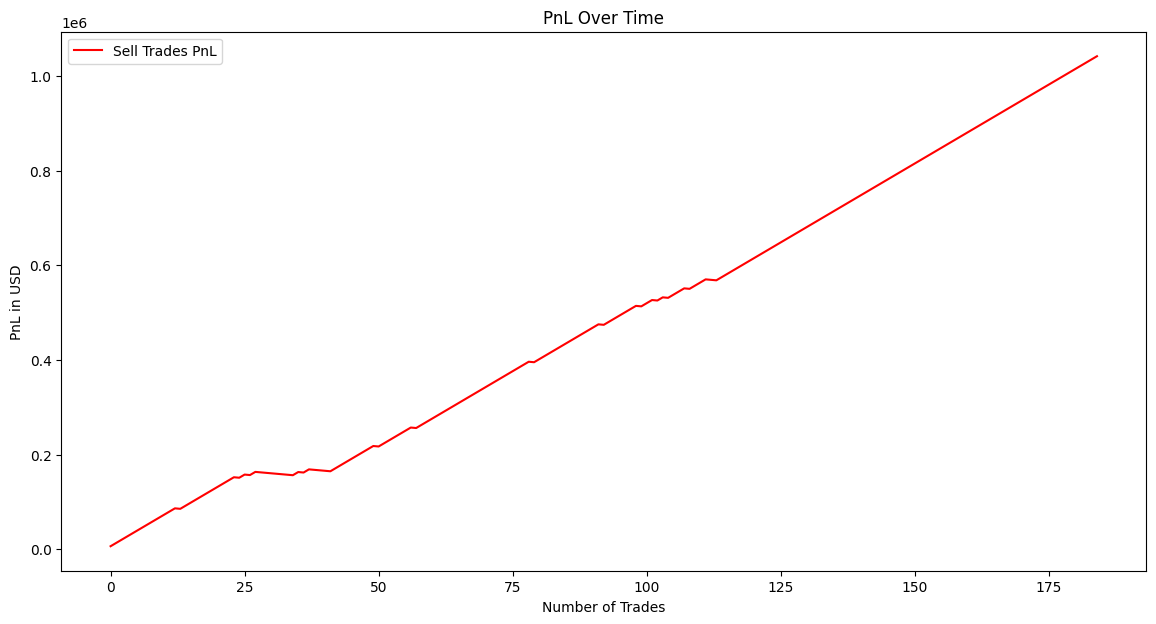

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


# **Maintenant nous allons faire une matrice des TP/SL pour trouver la meilleure combinaison**

[*********************100%%**********************]  1 of 1 completed


Matrice des résultats (capital final - capital initial) en millions de dollars:
                                                   30   \
50                                  24,274,823,543.98M   
100                  1,299,170,864,845,751,320,576.00M   
150      2,750,775,036,947,620,867,767,319,658,496.00M   
200  495,729,828,794,807,312,791,811,671,231,970,67...   
250  15,392,921,885,648,457,307,554,270,561,175,738...   
300  56,352,127,584,993,038,834,597,357,735,111,535...   
350  41,322,833,338,627,405,940,464,660,753,719,863...   
400  8,283,067,928,108,675,475,811,735,782,200,986,...   
450  572,396,724,502,536,010,412,888,925,943,299,55...   
500  17,242,719,851,830,741,292,022,001,290,141,301...   

                                                   60   \
50                                          26,976.74M   
100                                 24,274,823,543.98M   
150                          6,450,452,650,421,504.00M   
200                    677,747,745,832,531,263,48

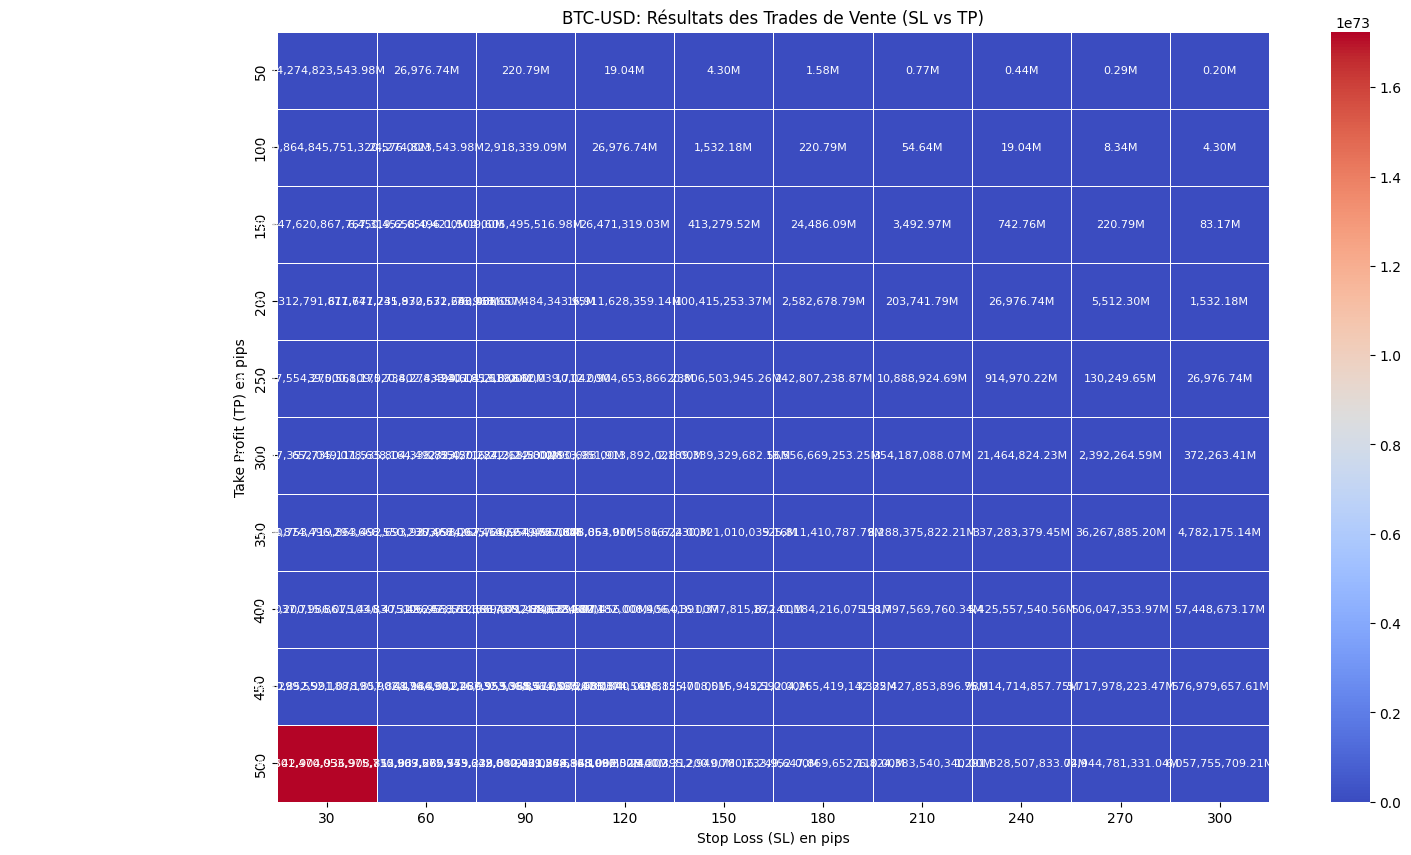

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Définir les paramètres
timeframes = ['1d']
period = '2y'
initial_capital = 10000
risk_per_trade = 0.1  # 10% du capital initial
sl_values = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300]
tp_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold):
    trades = []
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        position_size = (capital * risk_per_trade) / sl_pips
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                capital -= position_size * (sl_price - entry_price)
                trades.append((entry_date, entry_price, data.index[i], sl_price, 'SL', position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                capital += position_size * (entry_price - tp_price)
                trades.append((entry_date, entry_price, data.index[i], tp_price, 'TP', position_size, capital))
                break

            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Matrice pour stocker les résultats
results_matrix = pd.DataFrame(index=tp_values, columns=sl_values, dtype='float64')

# Itérer sur chaque combinaison de SL et TP
for sl in sl_values:
    for tp in tp_values:
        trades = apply_sl_tp(data, single_prints, sl, tp, 1)  # trailing_threshold=1 pour simplifier

        # Calculer la PnL
        pnl = [trade[6] for trade in trades]  # capital after trade
        final_capital = pnl[-1] if pnl else initial_capital
        results_matrix.at[tp, sl] = final_capital - initial_capital

# Remplir les valeurs manquantes avec 0
results_matrix.fillna(0, inplace=True)

# Convertir les valeurs en millions de dollars
results_matrix_m = results_matrix / 1e6

# Formater les valeurs pour les afficher en millions de dollars
def format_m(value):
    return '{:,.2f}M'.format(value) if value != 0 else '0'

results_matrix_formatted = results_matrix_m.applymap(format_m)

# Afficher la matrice des résultats
print("Matrice des résultats (capital final - capital initial) en millions de dollars:")
print(results_matrix_formatted)

# Visualiser la matrice des résultats
plt.figure(figsize=(16, 10))
sns.heatmap(results_matrix_m, annot=results_matrix_formatted.values, fmt='', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.title('BTC-USD: Résultats des Trades de Vente (SL vs TP)')
plt.xlabel('Stop Loss (SL) en pips')
plt.ylabel('Take Profit (TP) en pips')
plt.show()


# **testons 30 sl et 500 tp**

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 6666.67, Capital Before: 10000.00, Position Size: 13.33, Capital After: 16666.67
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 6666.67, Capital Before: 16666.67, Position Size: 13.33, Capital After: 23333.33
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 6666.67, Capital Before: 23333.33, Position Size: 13.33, Capital After: 30000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 6666.67, Capital Before: 30000.00, Position Size: 13.33, Capital After: 36666.67
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 6666.67, Capital Before: 36666.67, Position Size: 13.33, Capital After: 43333.33
Sell tra

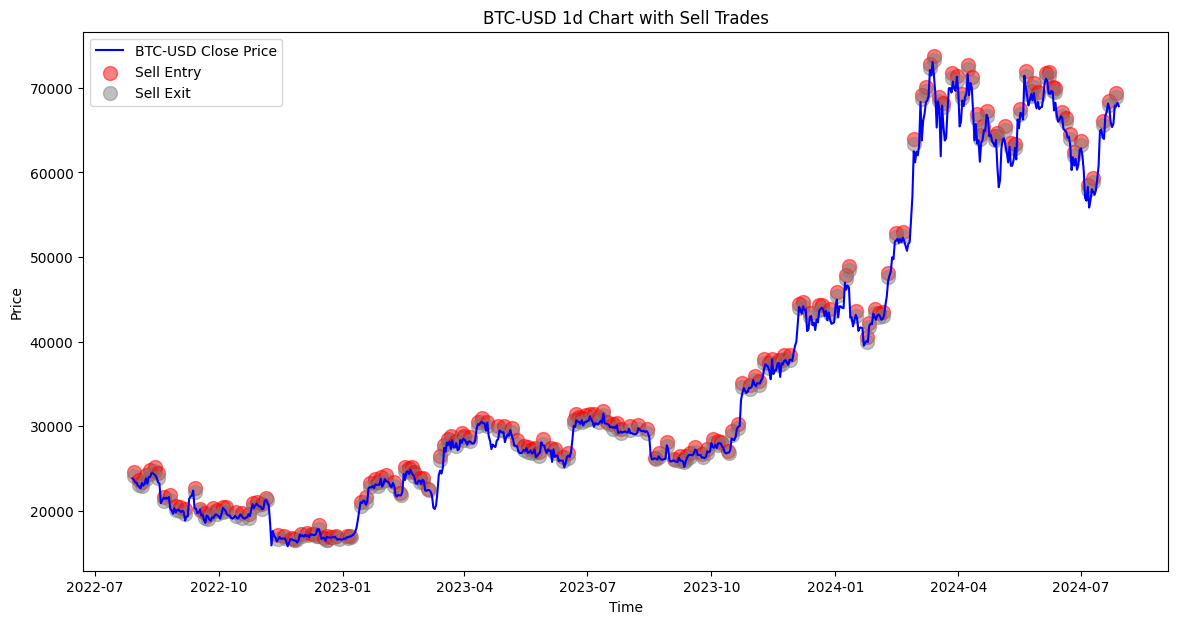


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  6666.67   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  6666.67   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  6666.67   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  6666.67   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  6666.67   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  6666.67   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  6666.67   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  6666.67   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  6666.67   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  6666.67   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          13.33             16666.67  
1        

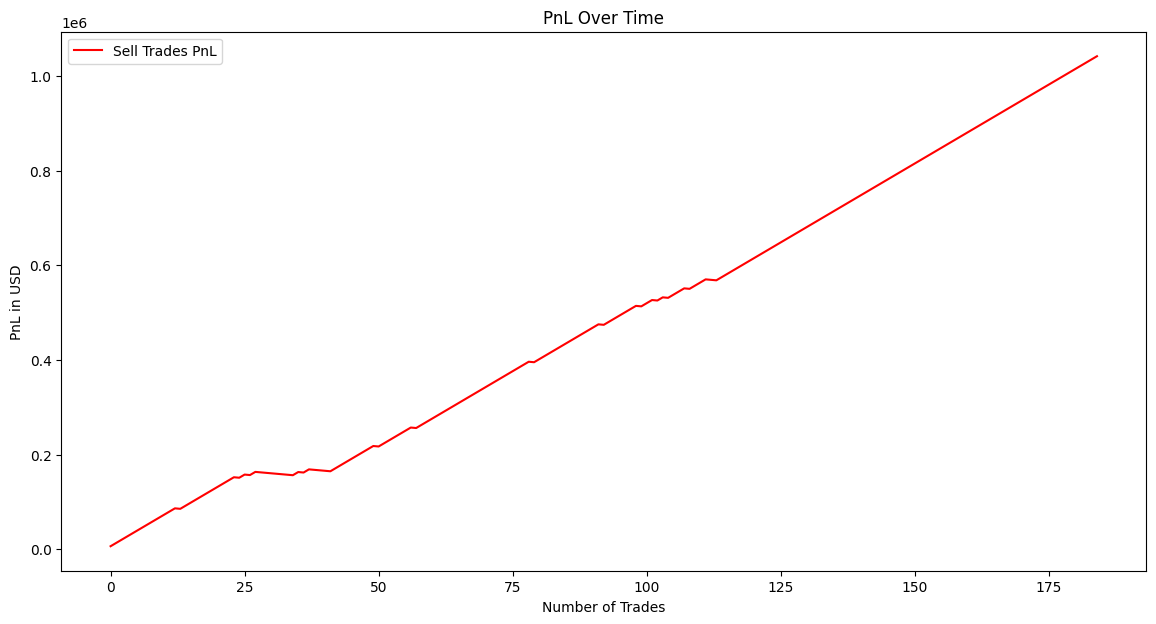

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


# **Testons 120 SL et 500 TP**

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 8333.33, Capital Before: 10000.00, Position Size: 16.67, Capital After: 18333.33
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 8333.33, Capital Before: 18333.33, Position Size: 16.67, Capital After: 26666.67
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 8333.33, Capital Before: 26666.67, Position Size: 16.67, Capital After: 35000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 8333.33, Capital Before: 35000.00, Position Size: 16.67, Capital After: 43333.33
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 8333.33, Capital Before: 43333.33, Position Size: 16.67, Capital After: 51666.67
Sell tra

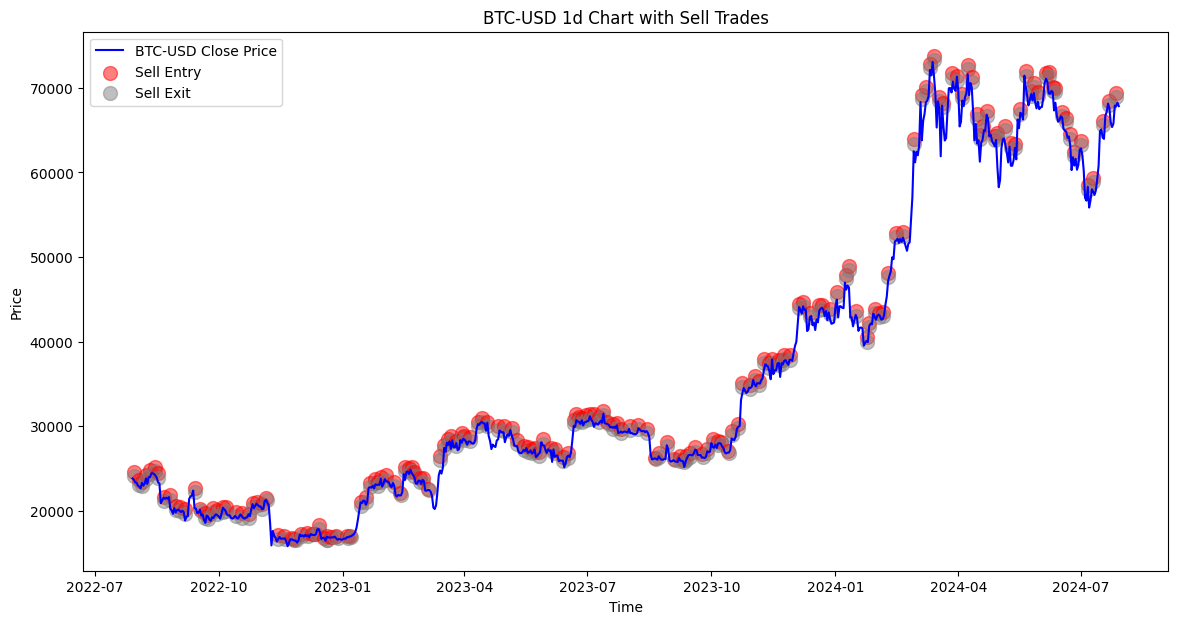


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  8333.33   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  8333.33   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  8333.33   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  8333.33   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  8333.33   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  8333.33   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  8333.33   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  8333.33   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  8333.33   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  8333.33   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          16.67             18333.33  
1        

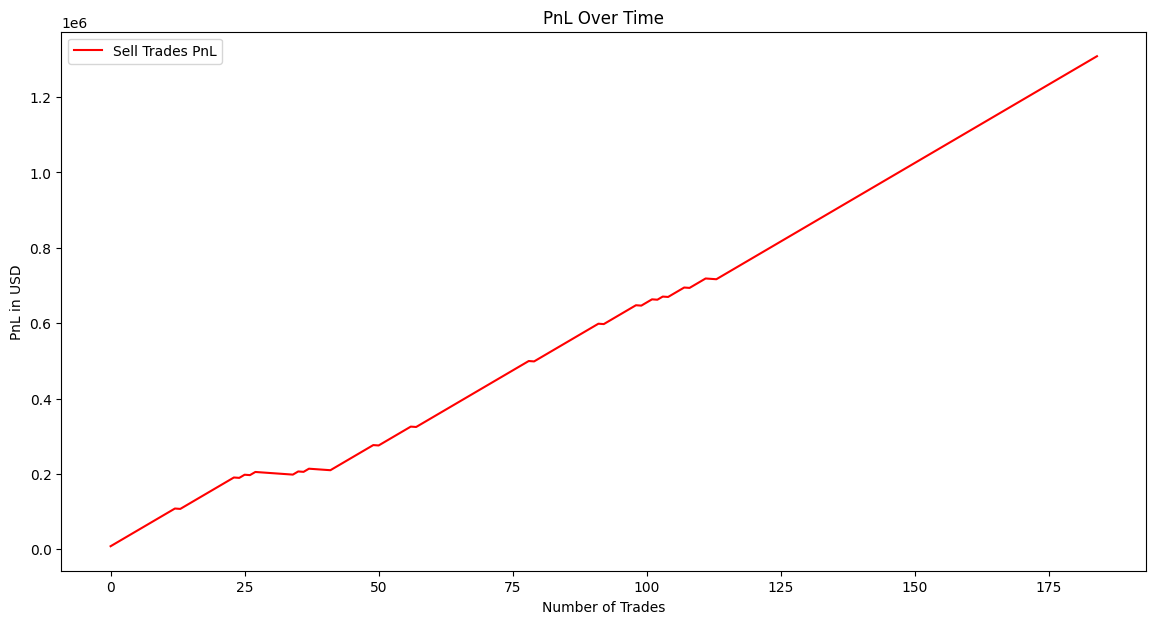

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 120
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


# **Testons 120 SL et 550 TP**

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24022.580078125 (TP), PnL: 9166.67, Capital Before: 10000.00, Position Size: 16.67, Capital After: 19166.67
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23028.650390625 (TP), PnL: 9166.67, Capital Before: 19166.67, Position Size: 16.67, Capital After: 28333.33
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22872.828125 (TP), PnL: 9166.67, Capital Before: 28333.33, Position Size: 16.67, Capital After: 37500.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23653.689453125 (TP), PnL: 9166.67, Capital Before: 37500.00, Position Size: 16.67, Capital After: 46666.67
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24272.62890625 (TP), PnL: 9166.67, Capital Before: 46666.67, Position Size: 16.67, Capital After: 55833.33
Sell tra

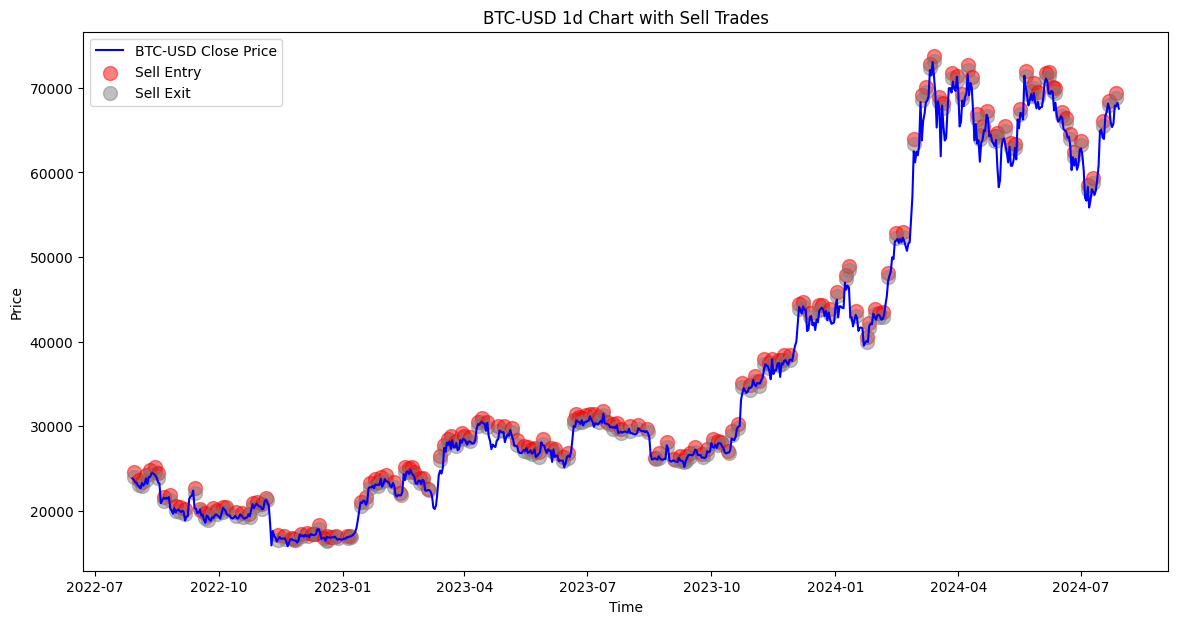


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24022.58     TP  9166.67   
1   2022-08-03     23578.65 2022-08-03    23028.65     TP  9166.67   
2   2022-08-05     23422.83 2022-08-05    22872.83     TP  9166.67   
3   2022-08-08     24203.69 2022-08-08    23653.69     TP  9166.67   
4   2022-08-11     24822.63 2022-08-11    24272.63     TP  9166.67   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57922.55     TP  9166.67   
181 2024-07-10     59359.43 2024-07-10    58809.43     TP  9166.67   
182 2024-07-17     66066.73 2024-07-17    65516.73     TP  9166.67   
183 2024-07-22     68480.06 2024-07-22    67930.06     TP  9166.67   
184 2024-07-27     69398.51 2024-07-27    68848.51     TP  9166.67   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          16.67             19166.67  
1        

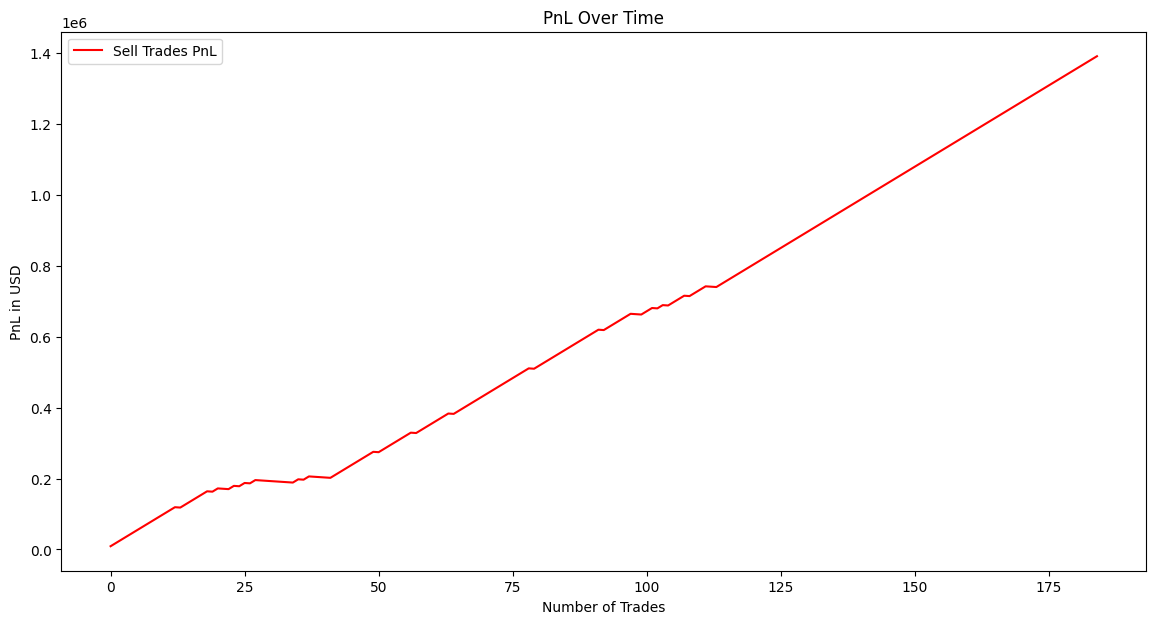

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 120
tp_pips = 550
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


Testons 600 de TP et 120 de SL

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 23972.580078125 (TP), PnL: 10000.00, Capital Before: 10000.00, Position Size: 16.67, Capital After: 20000.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 22978.650390625 (TP), PnL: 10000.00, Capital Before: 20000.00, Position Size: 16.67, Capital After: 30000.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22822.828125 (TP), PnL: 10000.00, Capital Before: 30000.00, Position Size: 16.67, Capital After: 40000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23603.689453125 (TP), PnL: 10000.00, Capital Before: 40000.00, Position Size: 16.67, Capital After: 50000.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24222.62890625 (TP), PnL: 10000.00, Capital Before: 50000.00, Position Size: 16.67, Capital After: 60000.00
Sel

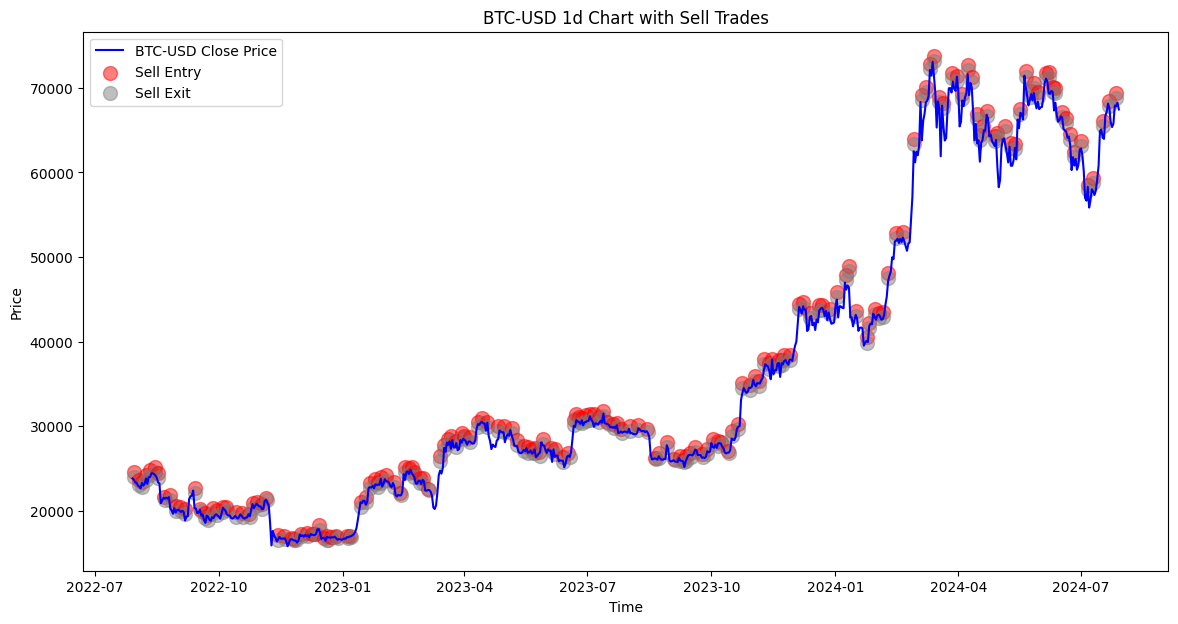


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    23972.58     TP  10000.0   
1   2022-08-03     23578.65 2022-08-03    22978.65     TP  10000.0   
2   2022-08-05     23422.83 2022-08-05    22822.83     TP  10000.0   
3   2022-08-08     24203.69 2022-08-08    23603.69     TP  10000.0   
4   2022-08-11     24822.63 2022-08-11    24222.63     TP  10000.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57872.55     TP  10000.0   
181 2024-07-10     59359.43 2024-07-10    58759.43     TP  10000.0   
182 2024-07-17     66066.73 2024-07-17    65466.73     TP  10000.0   
183 2024-07-22     68480.06 2024-07-22    67880.06     TP  10000.0   
184 2024-07-27     69398.51 2024-07-27    68798.51     TP  10000.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0          16.67              20000.0  
1        

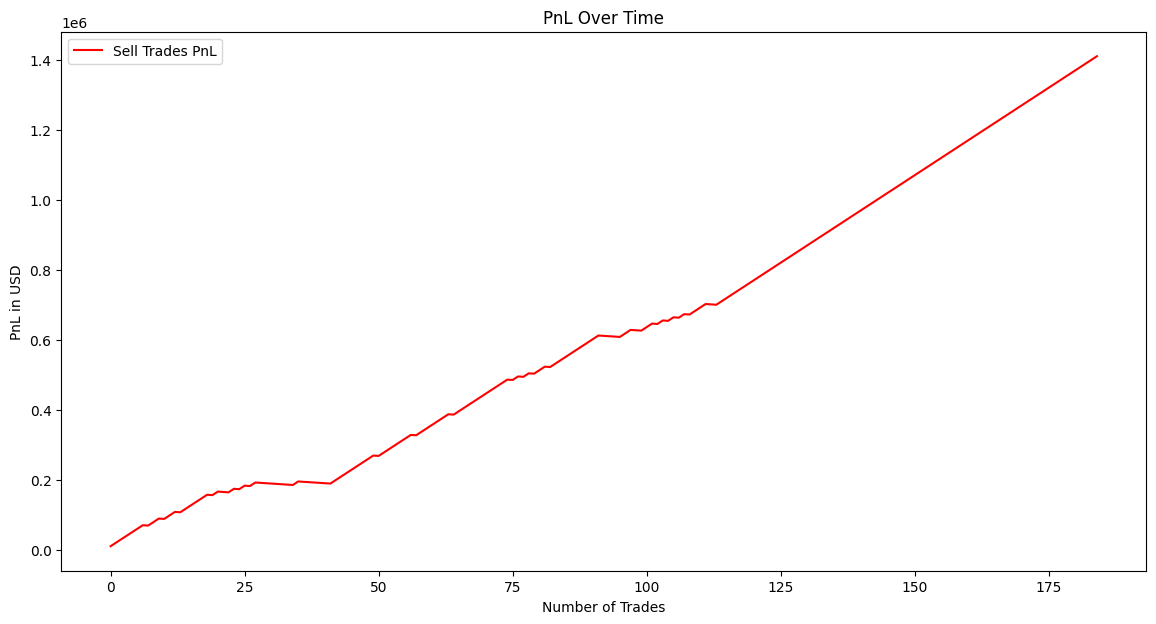

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 120
tp_pips = 600
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


TP: 400 / SL: 120

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24172.580078125 (TP), PnL: 6666.67, Capital Before: 10000.00, Position Size: 16.67, Capital After: 16666.67
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23178.650390625 (TP), PnL: 6666.67, Capital Before: 16666.67, Position Size: 16.67, Capital After: 23333.33
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 23022.828125 (TP), PnL: 6666.67, Capital Before: 23333.33, Position Size: 16.67, Capital After: 30000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23803.689453125 (TP), PnL: 6666.67, Capital Before: 30000.00, Position Size: 16.67, Capital After: 36666.67
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24422.62890625 (TP), PnL: 6666.67, Capital Before: 36666.67, Position Size: 16.67, Capital After: 43333.33
Sell tra

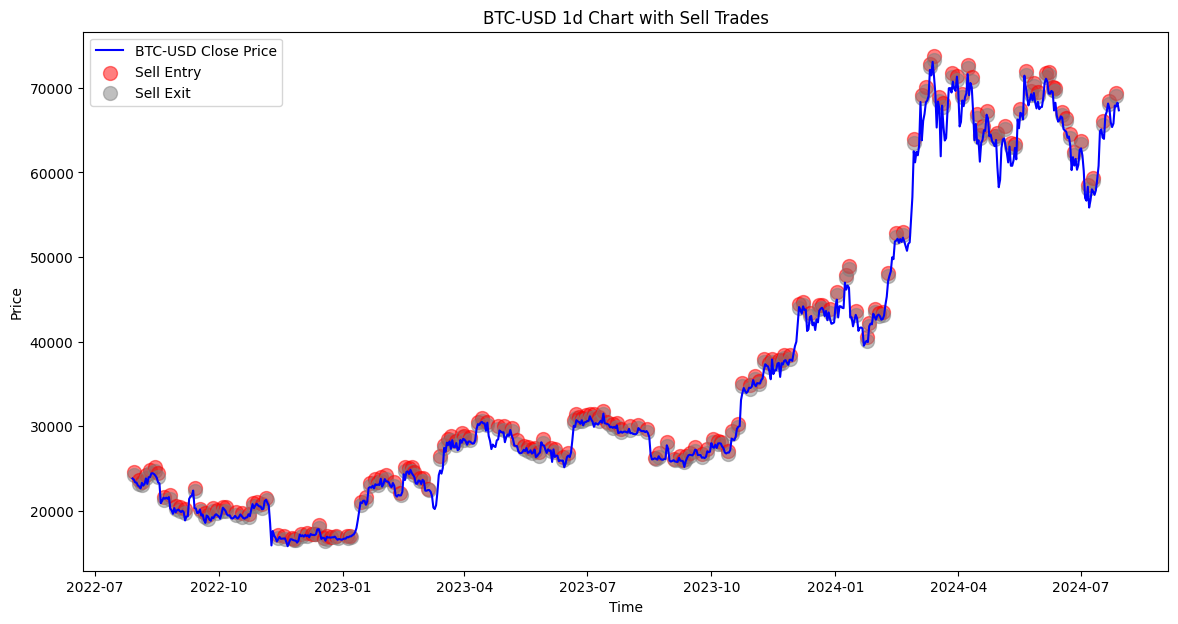


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24172.58     TP  6666.67   
1   2022-08-03     23578.65 2022-08-03    23178.65     TP  6666.67   
2   2022-08-05     23422.83 2022-08-05    23022.83     TP  6666.67   
3   2022-08-08     24203.69 2022-08-08    23803.69     TP  6666.67   
4   2022-08-11     24822.63 2022-08-11    24422.63     TP  6666.67   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    58072.55     TP  6666.67   
181 2024-07-10     59359.43 2024-07-10    58959.43     TP  6666.67   
182 2024-07-17     66066.73 2024-07-17    65666.73     TP  6666.67   
183 2024-07-22     68480.06 2024-07-22    68080.06     TP  6666.67   
184 2024-07-27     69398.51 2024-07-27    68998.51     TP  6666.67   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          16.67             16666.67  
1        

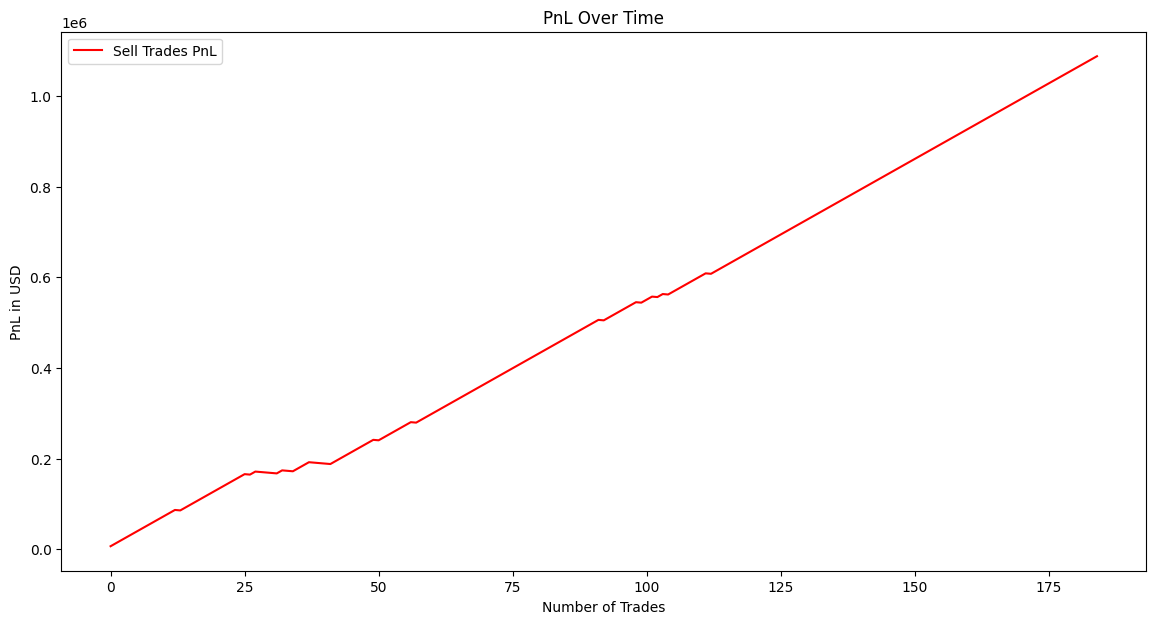

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 120
tp_pips = 400
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


500 TP / 180 SL

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 5555.56, Capital Before: 10000.00, Position Size: 11.11, Capital After: 15555.56
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 5555.56, Capital Before: 15555.56, Position Size: 11.11, Capital After: 21111.11
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 5555.56, Capital Before: 21111.11, Position Size: 11.11, Capital After: 26666.67
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 5555.56, Capital Before: 26666.67, Position Size: 11.11, Capital After: 32222.22
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 5555.56, Capital Before: 32222.22, Position Size: 11.11, Capital After: 37777.78
Sell tra

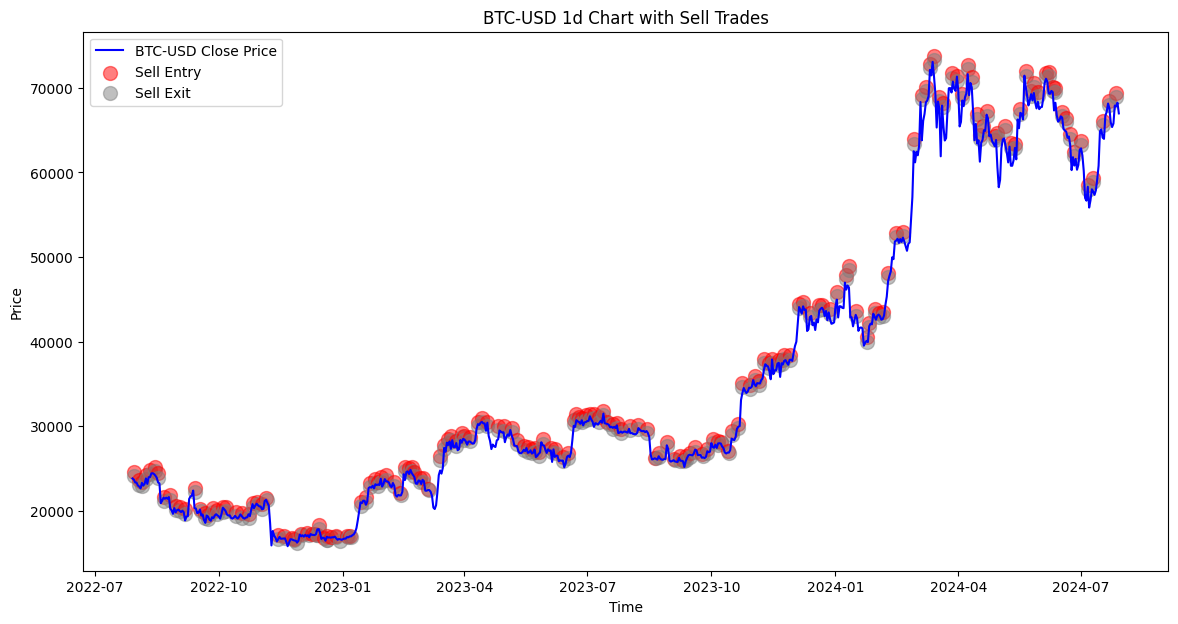


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  5555.56   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  5555.56   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  5555.56   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  5555.56   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  5555.56   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  5555.56   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  5555.56   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  5555.56   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  5555.56   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  5555.56   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          11.11             15555.56  
1        

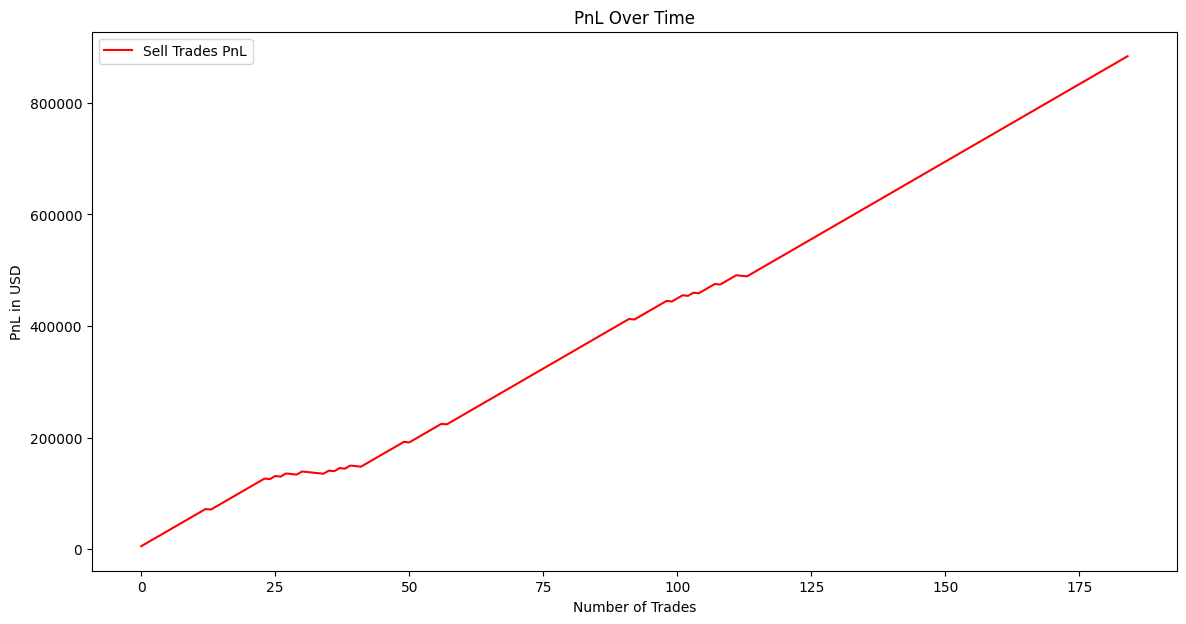

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 180
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


500 TP / 80 SL

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 12500.00, Capital Before: 10000.00, Position Size: 25.00, Capital After: 22500.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 12500.00, Capital Before: 22500.00, Position Size: 25.00, Capital After: 35000.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 12500.00, Capital Before: 35000.00, Position Size: 25.00, Capital After: 47500.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 12500.00, Capital Before: 47500.00, Position Size: 25.00, Capital After: 60000.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 12500.00, Capital Before: 60000.00, Position Size: 25.00, Capital After: 72500.00
Sel

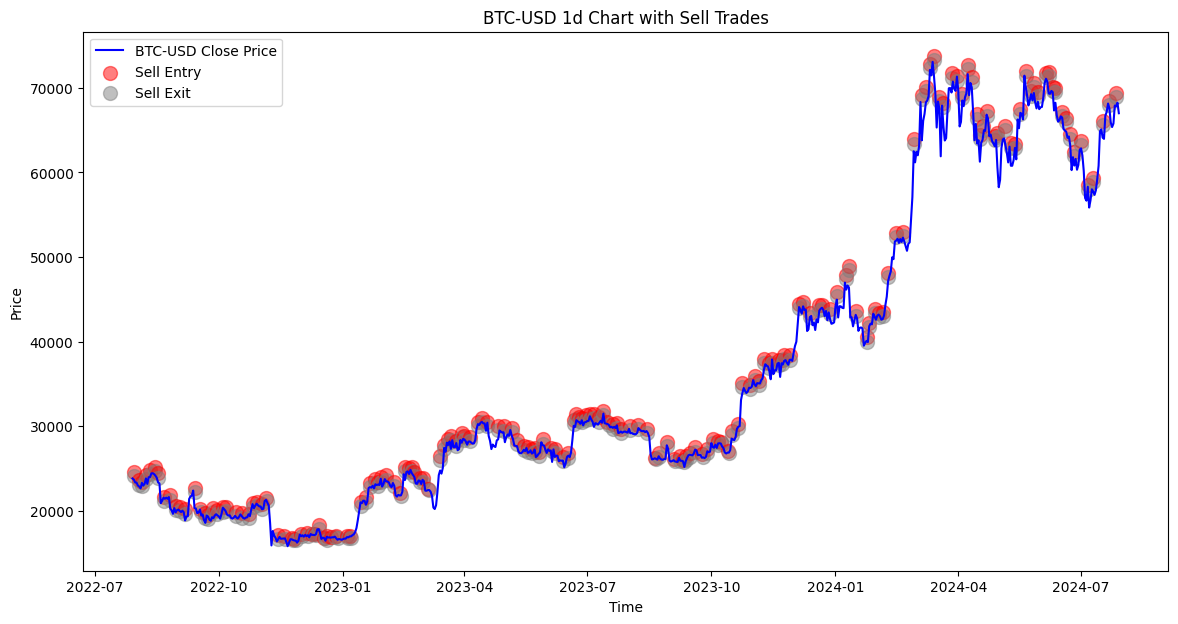


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  12500.0   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  12500.0   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  12500.0   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  12500.0   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  12500.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  12500.0   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  12500.0   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  12500.0   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  12500.0   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  12500.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0           25.0              22500.0  
1        

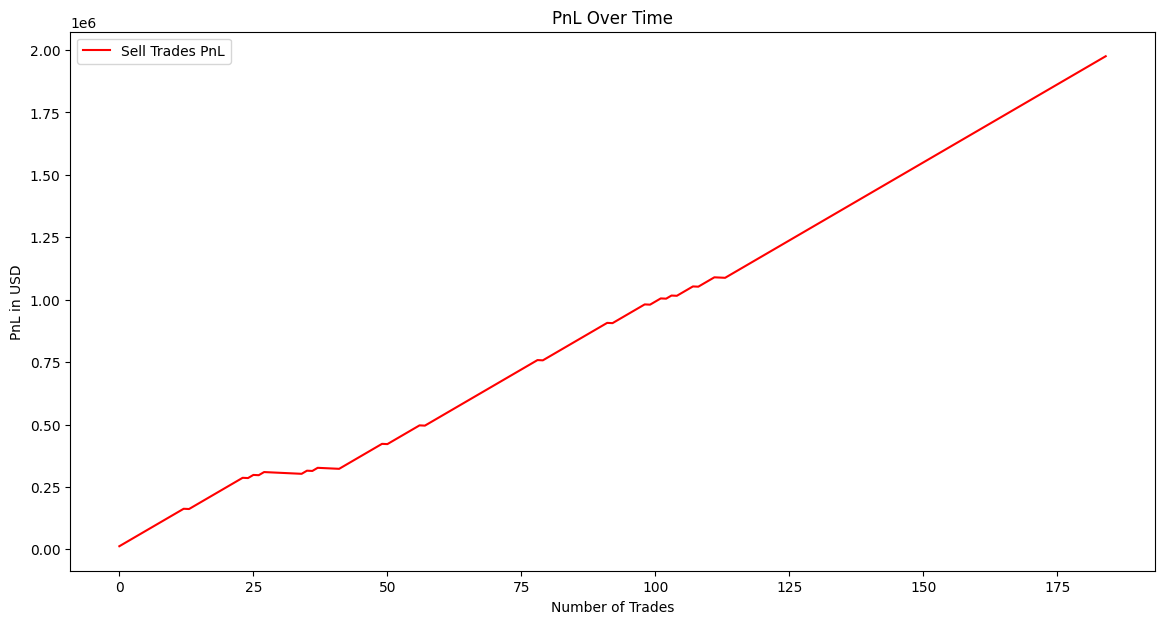

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 80
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


40 SL / 500 TP

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 25000.00, Capital Before: 10000.00, Position Size: 50.00, Capital After: 35000.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 25000.00, Capital Before: 35000.00, Position Size: 50.00, Capital After: 60000.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 25000.00, Capital Before: 60000.00, Position Size: 50.00, Capital After: 85000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 25000.00, Capital Before: 85000.00, Position Size: 50.00, Capital After: 110000.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 25000.00, Capital Before: 110000.00, Position Size: 50.00, Capital After: 135000.00


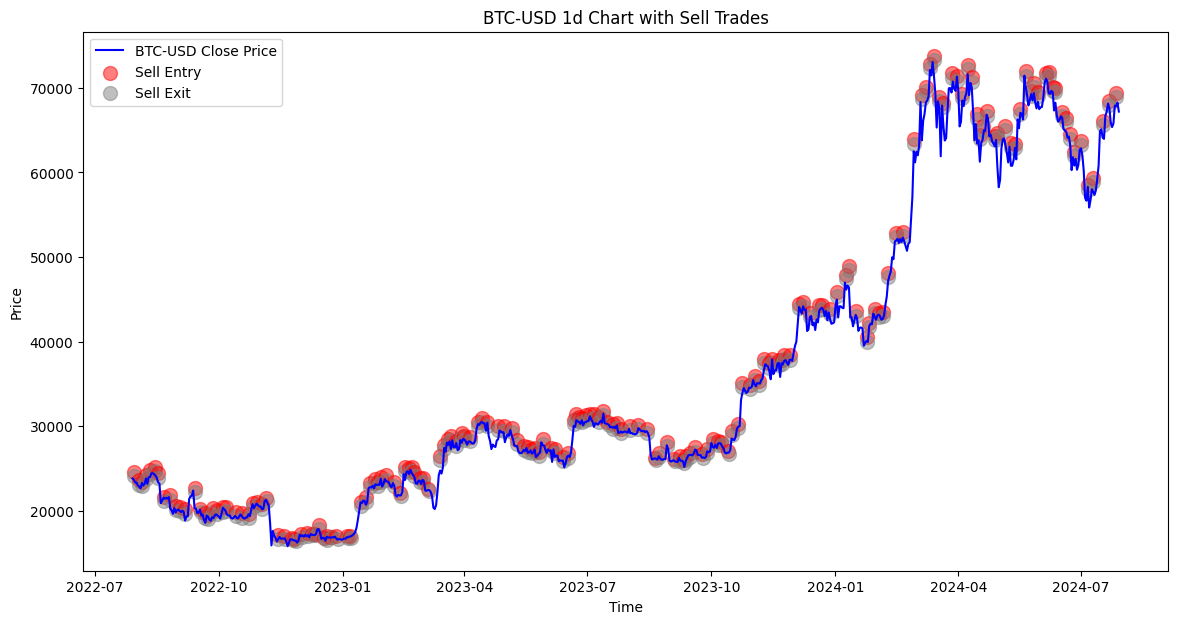


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  25000.0   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  25000.0   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  25000.0   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  25000.0   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  25000.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  25000.0   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  25000.0   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  25000.0   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  25000.0   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  25000.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0           50.0              35000.0  
1        

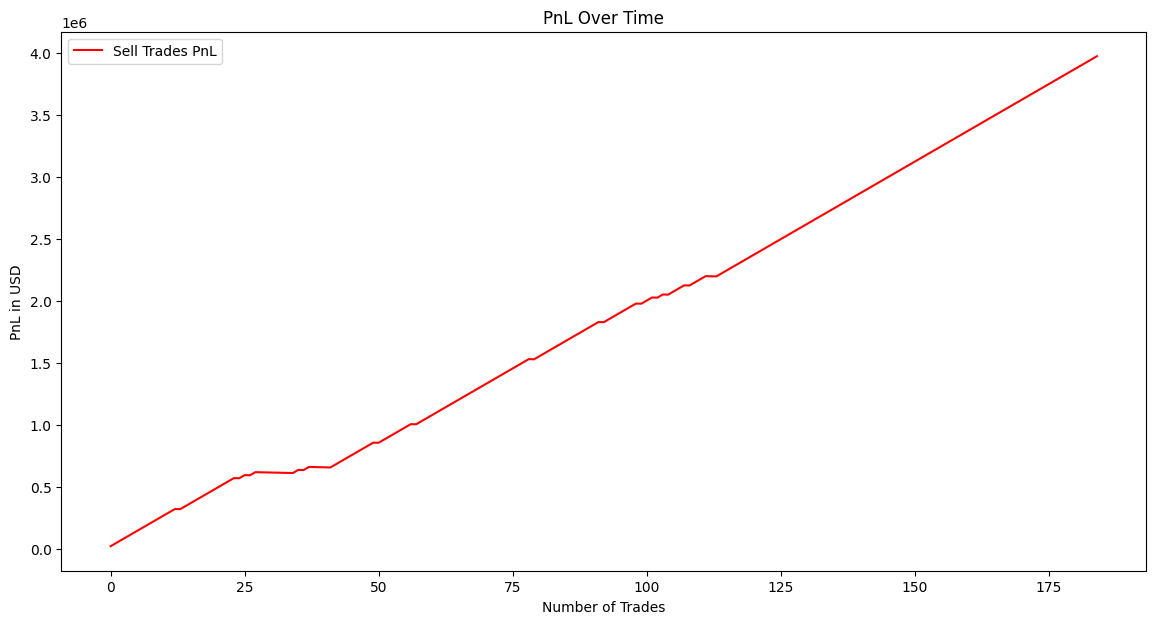

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 40
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


30 SL / 550 TP

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24022.580078125 (TP), PnL: 36666.67, Capital Before: 10000.00, Position Size: 66.67, Capital After: 46666.67
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23028.650390625 (TP), PnL: 36666.67, Capital Before: 46666.67, Position Size: 66.67, Capital After: 83333.33
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22872.828125 (TP), PnL: 36666.67, Capital Before: 83333.33, Position Size: 66.67, Capital After: 120000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23653.689453125 (TP), PnL: 36666.67, Capital Before: 120000.00, Position Size: 66.67, Capital After: 156666.67
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24272.62890625 (TP), PnL: 36666.67, Capital Before: 156666.67, Position Size: 66.67, Capital After: 193333.3

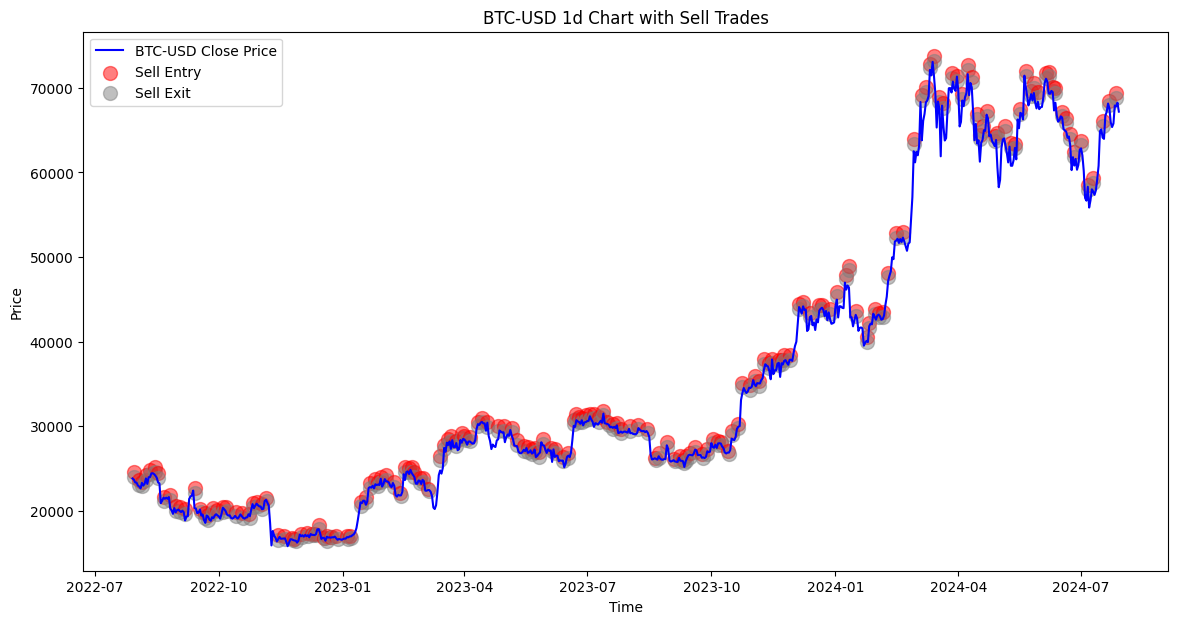


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result       PnL  \
0   2022-07-30     24572.58 2022-07-30    24022.58     TP  36666.67   
1   2022-08-03     23578.65 2022-08-03    23028.65     TP  36666.67   
2   2022-08-05     23422.83 2022-08-05    22872.83     TP  36666.67   
3   2022-08-08     24203.69 2022-08-08    23653.69     TP  36666.67   
4   2022-08-11     24822.63 2022-08-11    24272.63     TP  36666.67   
..         ...          ...        ...         ...    ...       ...   
180 2024-07-06     58472.55 2024-07-06    57922.55     TP  36666.67   
181 2024-07-10     59359.43 2024-07-10    58809.43     TP  36666.67   
182 2024-07-17     66066.73 2024-07-17    65516.73     TP  36666.67   
183 2024-07-22     68480.06 2024-07-22    67930.06     TP  36666.67   
184 2024-07-27     69398.51 2024-07-27    68848.51     TP  36666.67   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          66.67             46666.67

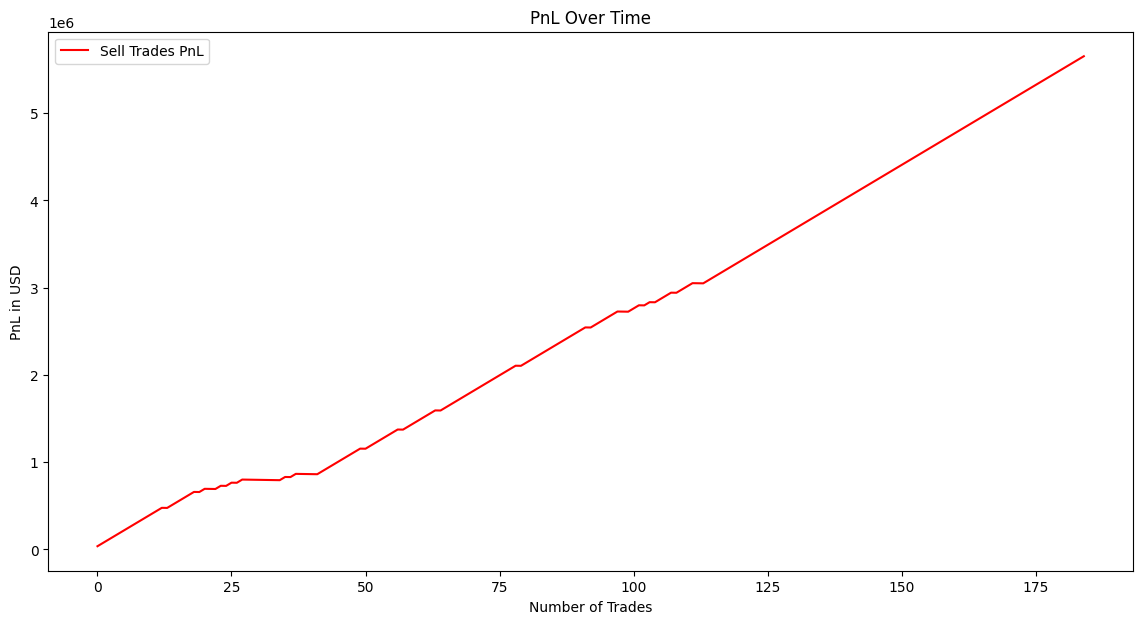

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 30
tp_pips = 550
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


500 TP / 30 SL

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 33333.33, Capital Before: 10000.00, Position Size: 66.67, Capital After: 43333.33
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 33333.33, Capital Before: 43333.33, Position Size: 66.67, Capital After: 76666.67
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 33333.33, Capital Before: 76666.67, Position Size: 66.67, Capital After: 110000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 33333.33, Capital Before: 110000.00, Position Size: 66.67, Capital After: 143333.33
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 33333.33, Capital Before: 143333.33, Position Size: 66.67, Capital After: 176666.6

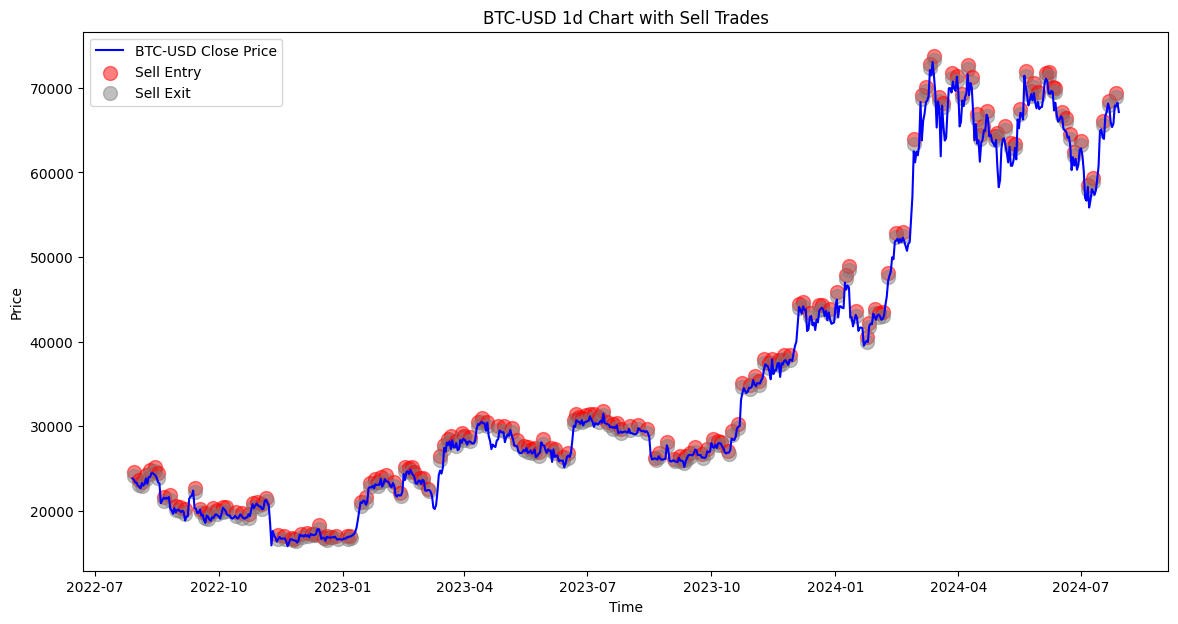


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result       PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  33333.33   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  33333.33   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  33333.33   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  33333.33   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  33333.33   
..         ...          ...        ...         ...    ...       ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  33333.33   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  33333.33   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  33333.33   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  33333.33   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  33333.33   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          66.67             43333.33

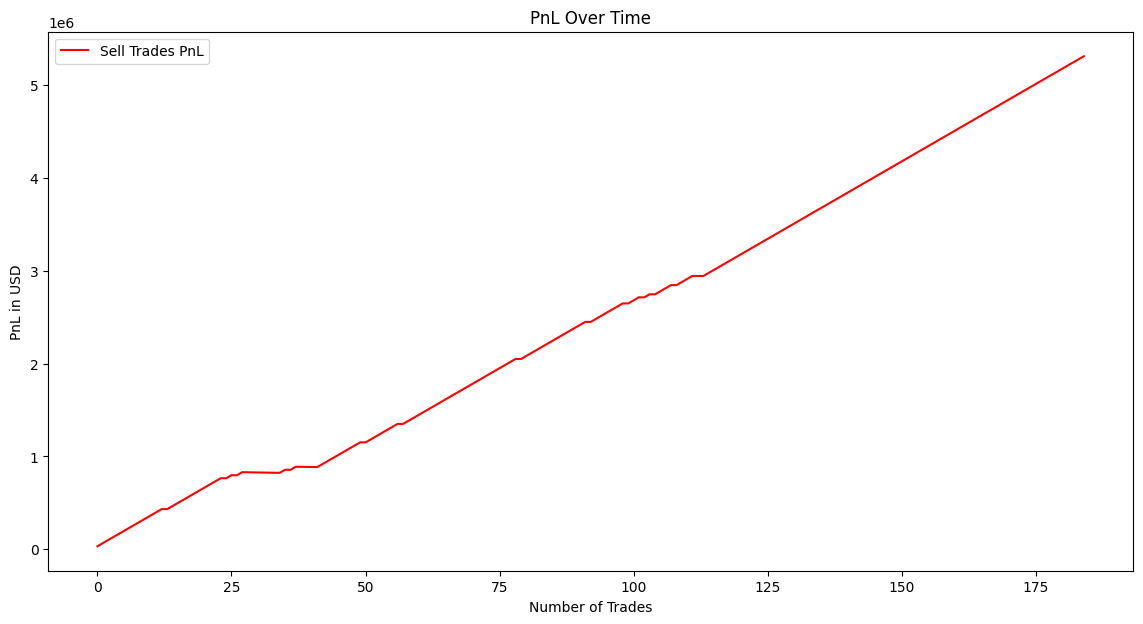

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 30
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


25 SL / 500 TP

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 40000.00, Capital Before: 10000.00, Position Size: 80.00, Capital After: 50000.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 40000.00, Capital Before: 50000.00, Position Size: 80.00, Capital After: 90000.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 40000.00, Capital Before: 90000.00, Position Size: 80.00, Capital After: 130000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 40000.00, Capital Before: 130000.00, Position Size: 80.00, Capital After: 170000.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 40000.00, Capital Before: 170000.00, Position Size: 80.00, Capital After: 210000.0

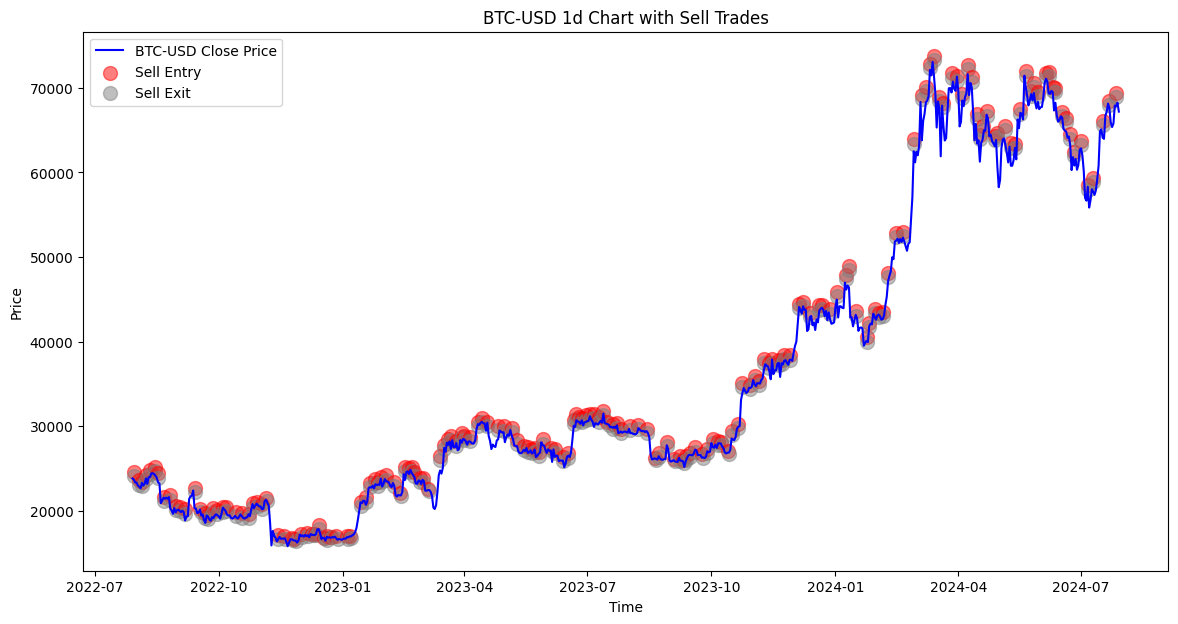


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  40000.0   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  40000.0   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  40000.0   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  40000.0   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  40000.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  40000.0   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  40000.0   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  40000.0   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  40000.0   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  40000.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0           80.0              50000.0  
1        

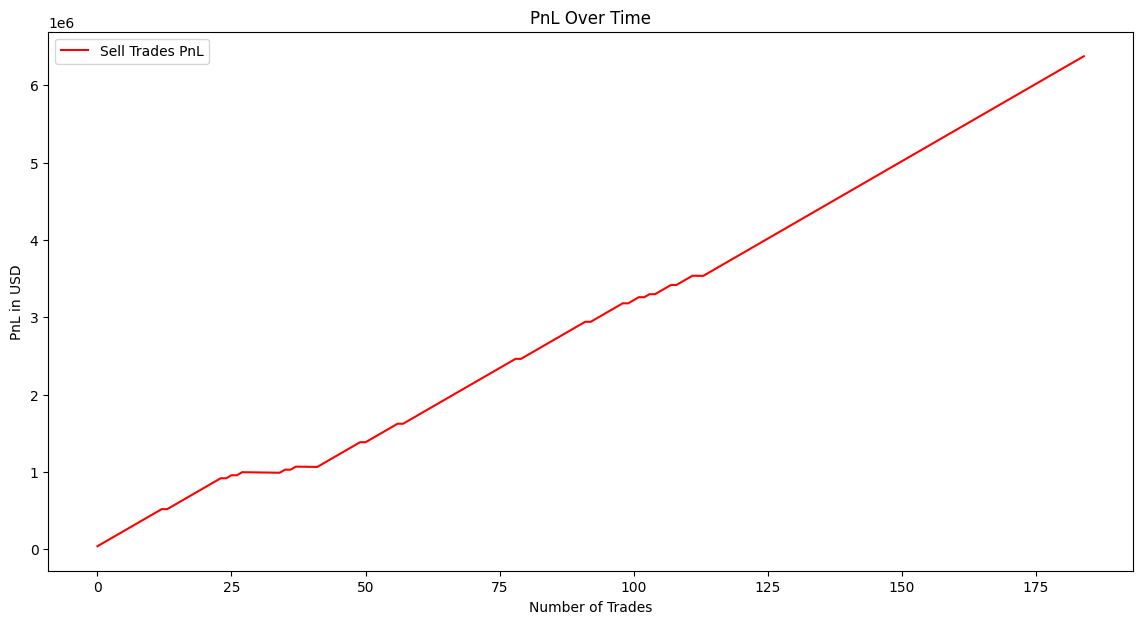

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 25
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


530 TP / 25 SL

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24042.580078125 (TP), PnL: 42400.00, Capital Before: 10000.00, Position Size: 80.00, Capital After: 52400.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23048.650390625 (TP), PnL: 42400.00, Capital Before: 52400.00, Position Size: 80.00, Capital After: 94800.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22892.828125 (TP), PnL: 42400.00, Capital Before: 94800.00, Position Size: 80.00, Capital After: 137200.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23673.689453125 (TP), PnL: 42400.00, Capital Before: 137200.00, Position Size: 80.00, Capital After: 179600.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24292.62890625 (TP), PnL: 42400.00, Capital Before: 179600.00, Position Size: 80.00, Capital After: 222000.0

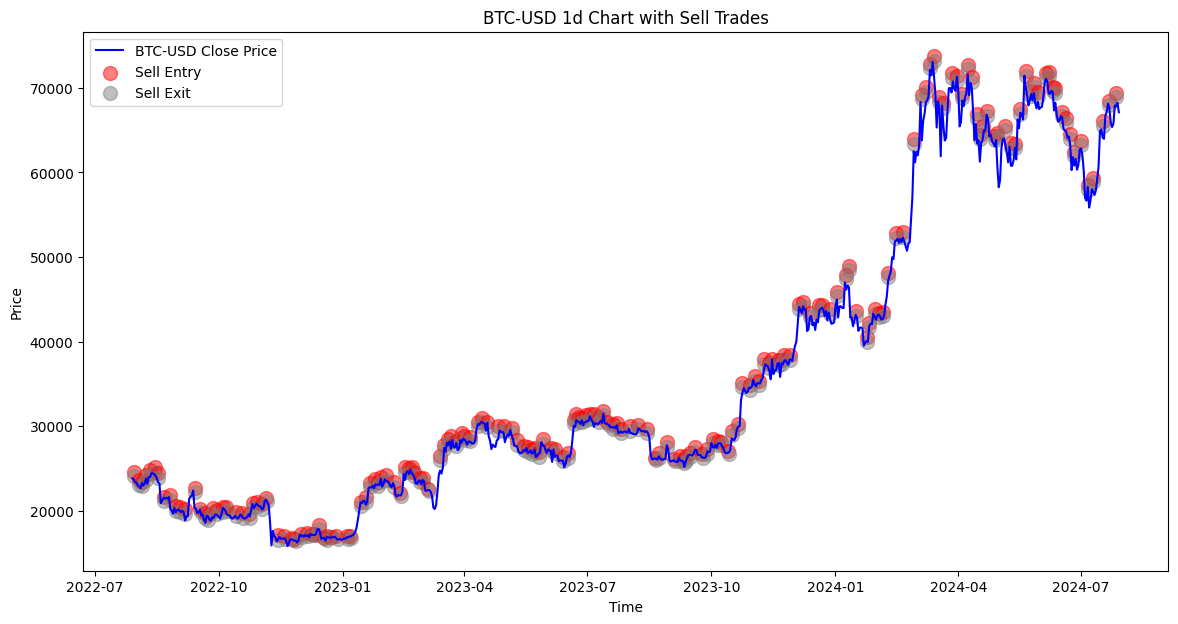


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24042.58     TP  42400.0   
1   2022-08-03     23578.65 2022-08-03    23048.65     TP  42400.0   
2   2022-08-05     23422.83 2022-08-05    22892.83     TP  42400.0   
3   2022-08-08     24203.69 2022-08-08    23673.69     TP  42400.0   
4   2022-08-11     24822.63 2022-08-11    24292.63     TP  42400.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57942.55     TP  42400.0   
181 2024-07-10     59359.43 2024-07-10    58829.43     TP  42400.0   
182 2024-07-17     66066.73 2024-07-17    65536.73     TP  42400.0   
183 2024-07-22     68480.06 2024-07-22    67950.06     TP  42400.0   
184 2024-07-27     69398.51 2024-07-27    68868.51     TP  42400.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0           80.0              52400.0  
1        

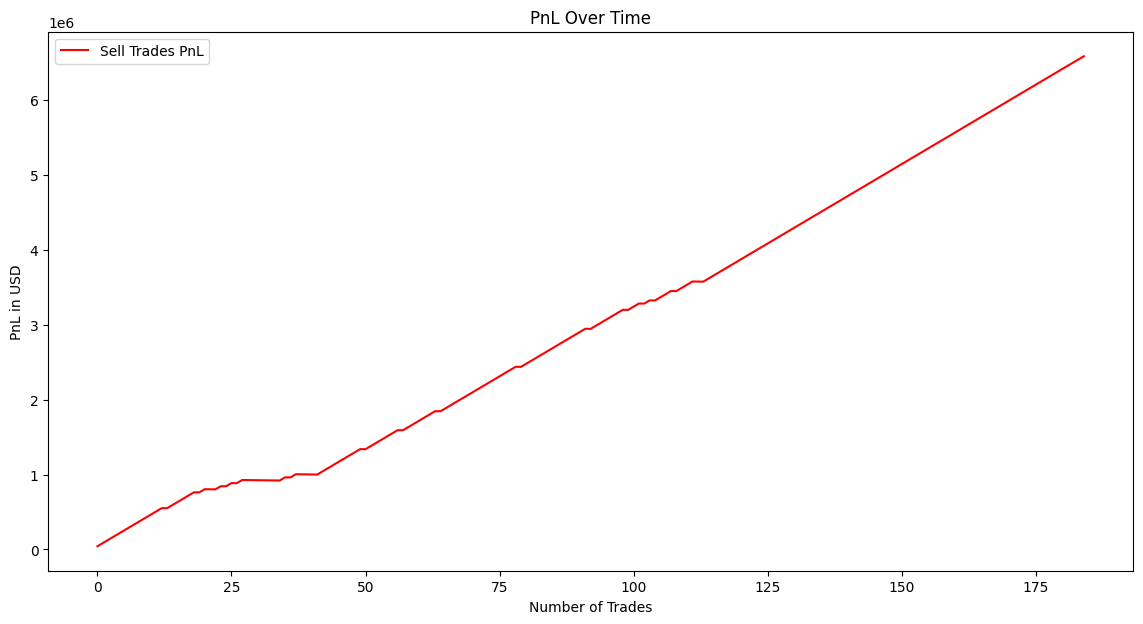

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 25
tp_pips = 530
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


515 pips et 25 SL

[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24057.580078125 (TP), PnL: 41200.00, Capital Before: 10000.00, Position Size: 80.00, Capital After: 51200.00
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23063.650390625 (TP), PnL: 41200.00, Capital Before: 51200.00, Position Size: 80.00, Capital After: 92400.00
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22907.828125 (TP), PnL: 41200.00, Capital Before: 92400.00, Position Size: 80.00, Capital After: 133600.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23688.689453125 (TP), PnL: 41200.00, Capital Before: 133600.00, Position Size: 80.00, Capital After: 174800.00
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24307.62890625 (TP), PnL: 41200.00, Capital Before: 174800.00, Position Size: 80.00, Capital After: 216000.0

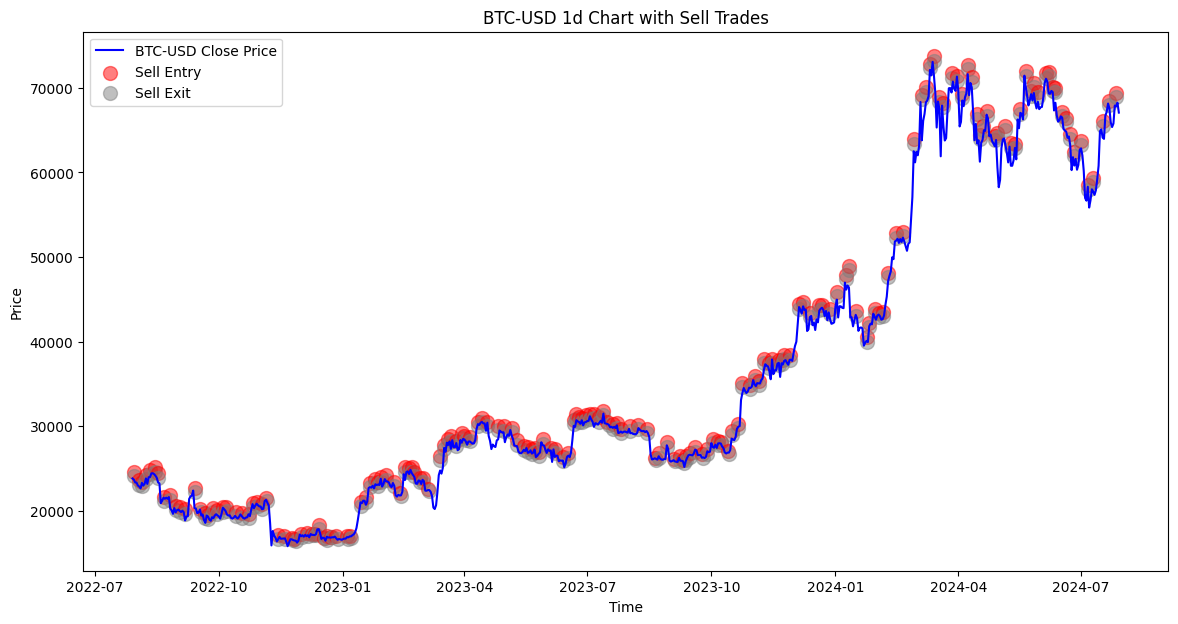


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24057.58     TP  41200.0   
1   2022-08-03     23578.65 2022-08-03    23063.65     TP  41200.0   
2   2022-08-05     23422.83 2022-08-05    22907.83     TP  41200.0   
3   2022-08-08     24203.69 2022-08-08    23688.69     TP  41200.0   
4   2022-08-11     24822.63 2022-08-11    24307.63     TP  41200.0   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57957.55     TP  41200.0   
181 2024-07-10     59359.43 2024-07-10    58844.43     TP  41200.0   
182 2024-07-17     66066.73 2024-07-17    65551.73     TP  41200.0   
183 2024-07-22     68480.06 2024-07-22    67965.06     TP  41200.0   
184 2024-07-27     69398.51 2024-07-27    68883.51     TP  41200.0   

     Capital Before Trade  Position Size  Capital After Trade  
0                 10000.0           80.0              51200.0  
1        

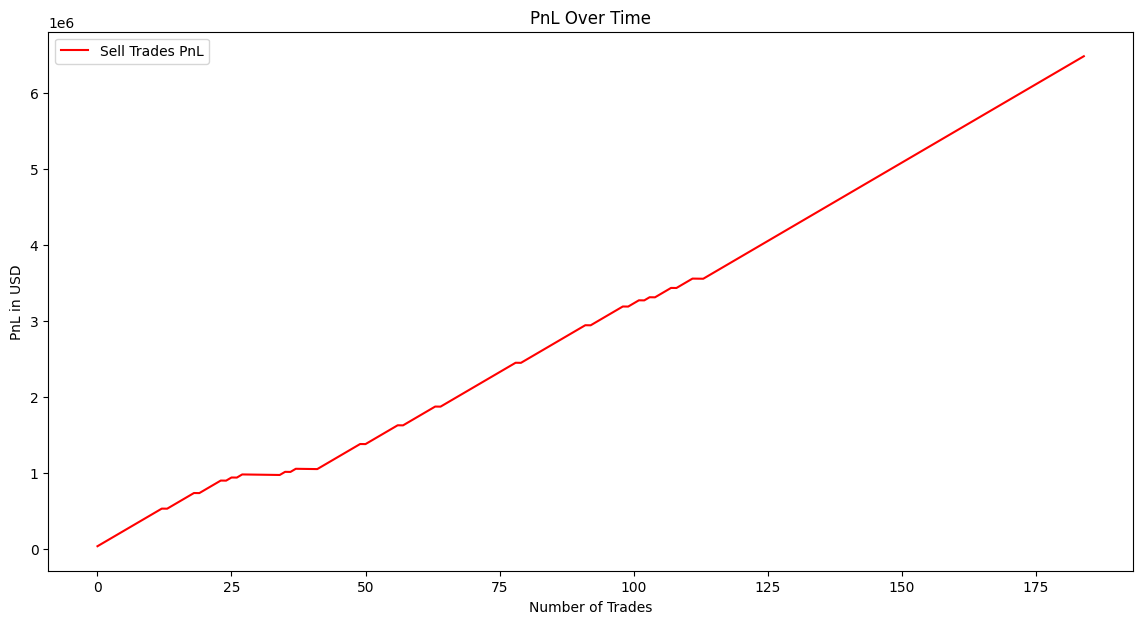

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 25
tp_pips = 515
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}
    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))
    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()
